# A Study of High School Factors Affecting Students' SAT Peformance

This study examines factors such as class size, school location, demographics, school safety, and more, on students' SAT performance. The sample consists of public schools (including charter schools) in New York, NY.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

# Load the data sets of interest into a list of files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

# Read each .csv file into a pandas dataframe and create
# a dictionary containing the various dataframes
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
# Each school has a unique 'DBN' identifier number
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


In [11]:
# print out the column names contained within the survey
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

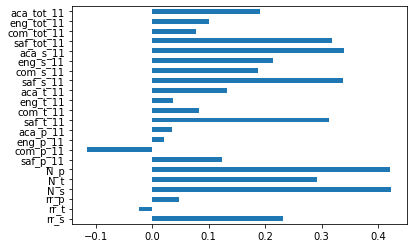

In [12]:
%matplotlib inline

correlations[survey_fields].plot.barh()

There are a number of correlations that seem surprising and one could say that the students' involvement with the mission and operations of the school makes the biggest difference. The surveyed factors of students' academic expectations and safety and respect are positively correlated with SAT scores. For the teachers surveyed, the safety factor was the one notable correlation.

Number of survey respondents made a notable positive correlation to SAT scores. 



# Plotting Safety Scores

Both teachers' and students' perceived safety and respect at school are correlated with SAT scores.

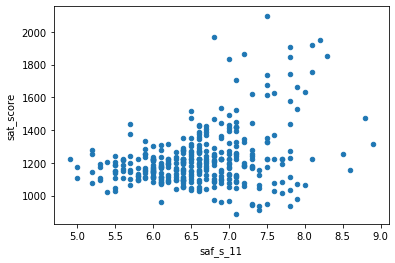

In [13]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

The correlation scatter plot of student safety ratings of a school show a positive correlation with SAT scores. So, as safety ratings are higher, there is a tendency for higher SAT scores.

There is a dense cluster of observations in the lower safety and lower SAT ranges of safety below 7 and SAT scores below 1400, so we need to look more deeply at safety scores by school district.

# Mapping Safety Scores

We'll use the average safety score listed in the 'saf_tot_11' column for each school to calculate the average safety and respct score for each school district (as identified in the 'school_dist' column) and then make a map that shows safety scores by district.

In [14]:
import numpy as np

# Aggregate the data by school district using mean calculations
dist_safety = combined.groupby('school_dist').agg(np.mean)

# The resulting dataframe includes average saftey scores and averaged latitude and longitude scores
dist_safety.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


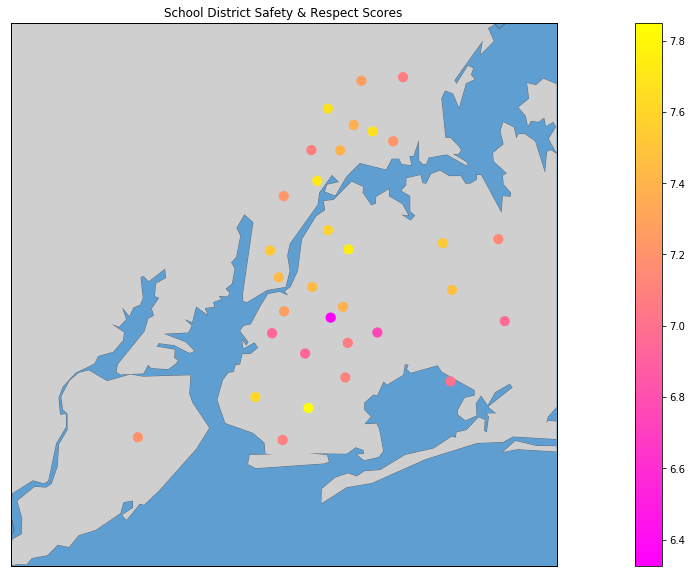

In [15]:
# Import libraries to import a web image and display it
from IPython.display import Image
from IPython.core.display import HTML

# Import libraries for mapping GPS coordinate of schools
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(projection='merc', llcrnrlat=40.496,urcrnrlat=40.915,\
            llcrnrlon=-74.255, urcrnrlon=-73.7, resolution='h')

longitudes = dist_safety['lon'].tolist()
latitudes = dist_safety['lat'].tolist()

plt.figure(figsize=(28,10))


m.fillcontinents(color=(207/255, 207/255, 207/255), lake_color='#DDEEFF')
m.drawcoastlines(color=(89/255, 89/255, 89/255), linewidth=.7, zorder=1)
m.drawmapboundary(fill_color=(95/255, 158/255, 209/255))

m.scatter(longitudes, latitudes, s=85, zorder=2, latlon=True, c=dist_safety['saf_tot_11'], cmap='spring')
plt.title('School District Safety & Respect Scores')
plt.colorbar()
plt.show()

Manhattan and The Bronx school districts have uniformly higher scores of safety and repect than Brooklyn and Queens. Brooklyn contains the widest variation of scores, with one high-scoring school in the heart of southern Brooklyn and several low-scoring schools in the heart of northern Brooklyn. Queens has scores closer to those of Manhattan and Bronx, but the school districts on the far east side of Queens have lower safety and respect scores. Staten Island has one reported score--a middling value of safety and respect.

In [16]:

Image(url= "https://www.worldatlas.com/r/w960-q50/upload/c6/23/73/shutterstock-152208935.jpg")

# Exploring Correlations of Ethnicity and SAT Scores

Enthicity data for asian, black, hispanic, and white populations is contained in the data set. Next, we'll explore the correlations between ethnicity and SAT score.

In [17]:
eth_cols = ['sat_score', 'asian_per', 'black_per', 'hispanic_per', 'white_per']
combined[eth_cols].head()

,sat_score,asian_per,black_per,hispanic_per,white_per
0,1122.0,14.0,29.1,53.8,1.7
1,1172.0,29.2,22.6,45.9,2.3
2,1149.0,9.7,23.9,55.4,10.4
3,1207.0,9.3,31.6,56.9,1.6
4,1621.0,27.8,11.7,14.2,44.9


In [18]:
# Create a correlation matrix between SAT score and ethnicity
combined_corr = combined[eth_cols].corr()
combined_corr

,sat_score,asian_per,black_per,hispanic_per,white_per
sat_score,1.000000,0.570730,-0.284139,-0.396985,0.620718
asian_per,0.570730,1.000000,-0.417373,-0.353186,0.349557
black_per,-0.284139,-0.417373,1.000000,-0.566739,-0.410717
hispanic_per,-0.396985,-0.353186,-0.566739,1.000000,-0.344970
white_per,0.620718,0.349557,-0.410717,-0.344970,1.000000


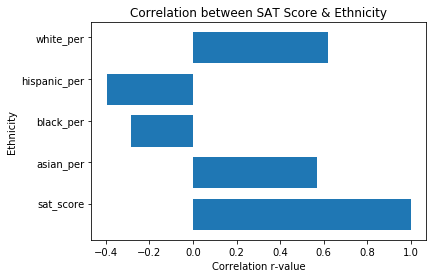

In [19]:
# Create a horizontal bar chart of the correlations

from numpy import arange

bar_widths = combined_corr.iloc[0].values
bar_positions = arange(5) + 0.75
tick_positions = range(1,6)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.75)
ax.set_yticks(tick_positions)
ax.set_yticklabels(eth_cols)
ax.set_ylabel('Ethnicity')
ax.set_xlabel('Correlation r-value')
ax.set_title('Correlation between SAT Score & Ethnicity')

plt.show()

Ethnicity and SAT are notably correlated (or negatively-correlated) for all ethnicities. The amount of correlation for all ethnicities was surprising (>.3 and <-.3 in all cases). Hispanics are most negatively affected, followed closely by Blacks. Asians and Whites have positive correlations between their ethnicity and SAT scores.

Of course, this all raises a number of questions and possibilities for other variables related to ethnicity. For instance, are many Hispanics located in school districts where there are factors such as safety or academic expectations that negatively influence SAT performance?

# Exploring Correlations of Gender and SAT Scores


In [20]:
# Create a list of columns of interest for gender and SAT score
gender_cols = ['sat_score', 'male_per', 'female_per']

# Create a correlation matrix of SAT score and percentage of females/males in schools
gender_corr = combined[gender_cols].corr()
gender_corr

,sat_score,male_per,female_per
sat_score,1.000000,-0.112062,0.112108
male_per,-0.112062,1.000000,-1.000000
female_per,0.112108,-1.000000,1.000000


In [21]:
gender_cols = gender_cols[1:]
gender_cols
gender_corr = gender_corr.drop('sat_score', axis=1)
gender_corr

,male_per,female_per
sat_score,-0.112062,0.112108
male_per,1.000000,-1.000000
female_per,-1.000000,1.000000


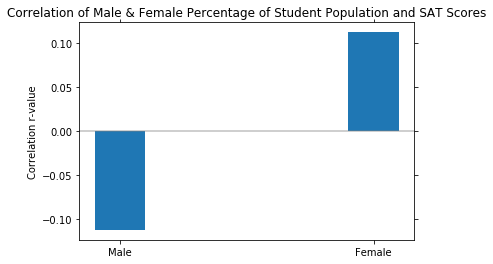

In [27]:
# Create a bar plot of the correlations

bar_heights = gender_corr.iloc[0].values
bar_positions = ['Male', 'Female']

fix, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, 0.2)
ax.axhline(0, color='grey', alpha=0.5)
ax.tick_params(bottom='off', top='off', left='off', right='off')
ax.set_title('Correlation of Male & Female Percentage of Student Population and SAT Scores')
ax.set_ylabel('Correlation r-value')

plt.show()

While not a strong correlation, there is an opposing trend between male and female percentages of the student population and SAT scores. Higher female students in the school are correlated with slightly better SAT performance.

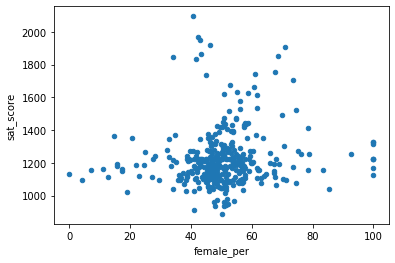

In [23]:
combined.plot.scatter(x='female_per', y='sat_score')

In [24]:
# Create list of schools with a 60% or greater female percentage and
# average SAT scores greater than 1700

fem_schools_mask = (combined['female_per'] > 0.6) & (combined['sat_score'] > 1700)

top_fem_schools = combined[fem_schools_mask]
top_fem_schools['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These top schools are academically accelerated magnet schools with either pre-college formats or specialties in STEM or Libral Arts.

# Exploring AP Test Taking and SAT Scores

Next, we'll explore the percentage of AP test takers as percentage of the total school population and the relationship to SAT scores.

In [25]:
# Create a new column of the percentage of AP test takers
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

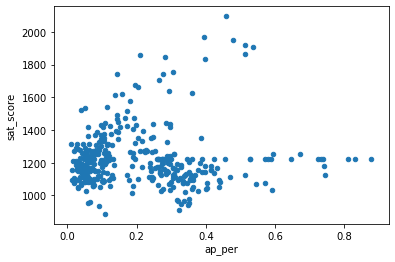

In [26]:
combined.plot.scatter(x='ap_per', y='sat_score')

Overall, there is an expected positive correlation between a higher percentage of AP test takers at a school and average SAT scores. However, the scatter plot diverges into a forked pattern:

- the upper fork reflects the positive correlation and SAT scores are maximized in a few cases where approximately 50% of students take AP exams.
- the lower fork contains a dense cluster of scorres between 1000-1200 and exhibits a slight downward trajectory as AP test takers go from 20-40% of the population.
    - Further on, schools with much higher percentages of AP test takers, struggle to break the 1200 average score barrier.
    
The results may indicate that compulsory or incentivized schemes to increase AP test taking may actually inhibit students on average from excelling in the SAT test. Perhaps the time committment for preparing for the AP test leaves little time for SAT preparation. Combined with the time committment, perhaps higher percentages of AP test taking correspond to earlier AP test taking and thus double committments in the junior year as students juggle the SAT and AP tests.

# (Next steps for research...)

- Determine wheter there's a correlation between class size and SAT scores
- Figure out which neighborhoods have the best schools
    - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigate the differences between parent, teacher, and student responses to surveys.
- Assign scores to schools based on sat_score and other attributes.